# Worldwide Box Office Analysis (2019–2023)

This notebook scrapes worldide box office data from **Box Office Mojo** for the years **2019–2023**. Each annual page list films ranked by worldwide gross with domestic and foriegn earnings and percentage shares. 

The goal is to bulid a consolidated dataset, clean and tranform the data, and perform exploratary analysis to answer severel questions about recent global box office trends.

The data is sourced form the following pages:

- [2019 Worldwide Box Office](https://www.boxofficemojo.com/year/world/2019/)
- [2020 Worldwide Box Office](https://www.boxofficemojo.com/year/world/2020/)
- [2021 Worldwide Box Office](https://www.boxofficemojo.com/year/world/2021/)
- [2022 Worldwide Box Office](https://www.boxofficemojo.com/year/world/2022/)
- [2023 Worldwide Box Office](https://www.boxofficemojo.com/year/world/2023/)

## Questions to Answer

1. **How has the average worldwide gross of the top 10 films changed from 2019 to 2023?**
2. **What is the average domestic share (%) of revenue for films each year?**
3. **How do domestic and foriegn grosses relate each other across all films?**
4. **Which films had the highest ratio of domestic gross to worldwide gross across the dataset?**



In [1]:

import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot aesthetics
sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 100


In [2]:

# Define years to scrape and base URL
years = [2019, 2020, 2021, 2022, 2023]
base_url = 'https://www.boxofficemojo.com/year/world/'

frames = []

for year in years:
    url = f"{base_url}{year}/"
    # Use pandas to read the first table on the page
    df_year = pd.read_html(url)[0]
    # Rename ambiguous columns to meaningful names
    df_year.columns = ['Rank', 'Release Group', 'Worldwide', 'Domestic', 'DomesticShare', 'Foreign', 'ForeignShare']
    df_year['Year'] = year
    frames.append(df_year)

# Concatenate all yearly DataFrames into one
boxoffice_df = pd.concat(frames, ignore_index=True)

# Display the first few rows of the raw dataset
boxoffice_df.head()


,Rank,Release Group,Worldwide,Domestic,DomesticShare,Foreign,ForeignShare,Year
0,1,Avengers: Endgame,"$2,799,439,100","$858,373,000",30.7%,"$1,941,066,100",69.3%,2019
1,2,The Lion King,"$1,656,943,394","$543,638,043",32.8%,"$1,113,305,351",67.2%,2019
2,3,Frozen II,"$1,450,026,933","$477,373,578",32.9%,"$972,653,355",67.1%,2019
3,4,Spider-Man: Far from Home,"$1,131,927,996","$390,532,085",34.5%,"$741,395,911",65.5%,2019
4,5,Captain Marvel,"$1,128,274,794","$426,829,839",37.8%,"$701,444,955",62.2%,2019


In [3]:
# Replace missing values represented as '-' with zeros in numeric columns
for col in ['Worldwide', 'Domestic', 'Foreign']:
    boxoffice_df[col] = boxoffice_df[col].replace('-', '0')
    boxoffice_df[col] = boxoffice_df[col].str.replace(r'[$,]', '', regex=True).astype(float)

# Clean percentage columns by removing '%' and '<' symbols and converting to float
for col in ['DomesticShare', 'ForeignShare']:
    boxoffice_df[col] = boxoffice_df[col].replace('-', '0')
    boxoffice_df[col] = boxoffice_df[col].astype(str).str.replace('%', '', regex=False)
    boxoffice_df[col] = boxoffice_df[col].str.replace('<', '', regex=False)
    boxoffice_df[col] = boxoffice_df[col].astype(float)

# Compute domestic ratio as a check (Domestic / Worldwide * 100)
boxoffice_df['DomesticRatio'] = (boxoffice_df['Domestic'] / boxoffice_df['Worldwide']) * 100

# Inspect the cleaned DataFrame
boxoffice_df.head()


,Rank,Release Group,Worldwide,Domestic,DomesticShare,Foreign,ForeignShare,Year,DomesticRatio
0,1,Avengers: Endgame,2.799439e+09,858373000.0,30.7,1.941066e+09,69.3,2019,30.662321
1,2,The Lion King,1.656943e+09,543638043.0,32.8,1.113305e+09,67.2,2019,32.809693
2,3,Frozen II,1.450027e+09,477373578.0,32.9,9.726534e+08,67.1,2019,32.921704
3,4,Spider-Man: Far from Home,1.131928e+09,390532085.0,34.5,7.413959e+08,65.5,2019,34.501495
4,5,Captain Marvel,1.128275e+09,426829839.0,37.8,7.014450e+08,62.2,2019,37.830309


C:\Users\sahit\AppData\Local\Temp\ipykernel_9608\2023456554.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.head(10)['Worldwide'].mean()))
C:\Users\sahit\AppData\Local\Temp\ipykernel_9608\2023456554.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=avg_top10_billion.index, y=avg_top10_billion.values, palette='crest')


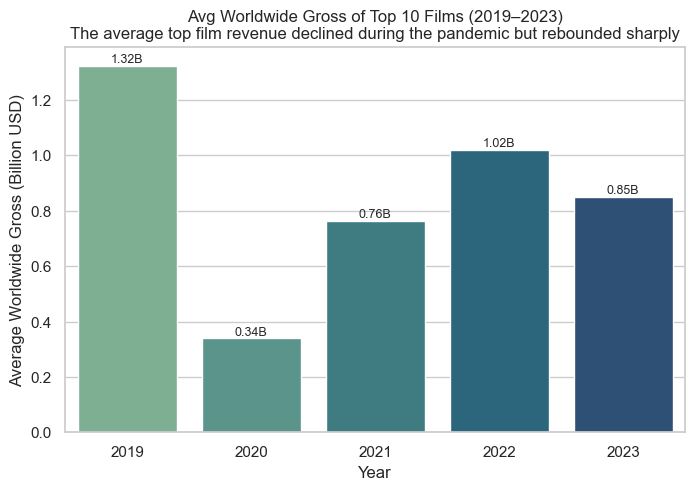

Year
2019    1.324529
2020    0.338842
2021    0.763976
2022    1.021360
2023    0.851581
dtype: float64

In [4]:
# Question 1: Average worldwide gross of the top 10 films each year

# For each year, sort by Rank and take the top 10 films then compute the average worldwide gross
avg_top10 = (boxoffice_df.sort_values('Rank')
                        .groupby('Year')
                        .apply(lambda x: x.head(10)['Worldwide'].mean()))

# Convert gross to billions for readability
avg_top10_billion = avg_top10 / 1e9

# Plot the average gross per year
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=avg_top10_billion.index, y=avg_top10_billion.values, palette='crest')

# Add data labels on top of bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}B", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Year')
ax.set_ylabel('Average Worldwide Gross (Billion USD)')
ax.set_title('Avg Worldwide Gross of Top 10 Films (2019–2023)\nThe average top film revenue declined during the pandemic but rebounded sharply')
plt.show()

# Display the computed averages
avg_top10_billion


C:\Users\sahit\AppData\Local\Temp\ipykernel_9608\1319570865.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=avg_dom_share.index, y=avg_dom_share.values, palette='flare')


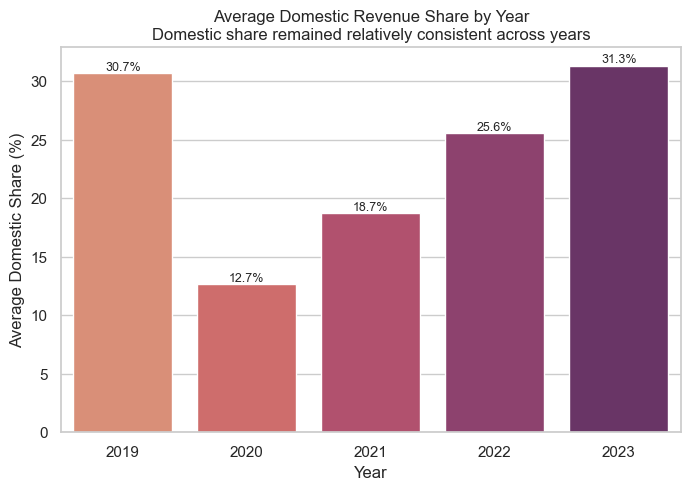

Year
2019    30.6805
2020    12.6690
2021    18.7235
2022    25.5605
2023    31.3385
Name: DomesticShare, dtype: float64

In [5]:
# Question 2: Average domestic share (%) of revenue each year

avg_dom_share = boxoffice_df.groupby('Year')['DomesticShare'].mean()

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=avg_dom_share.index, y=avg_dom_share.values, palette='flare')

# Add data labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Year')
ax.set_ylabel('Average Domestic Share (%)')
ax.set_title('Average Domestic Revenue Share by Year\nDomestic share remained relatively consistent across years')
plt.show()

avg_dom_share


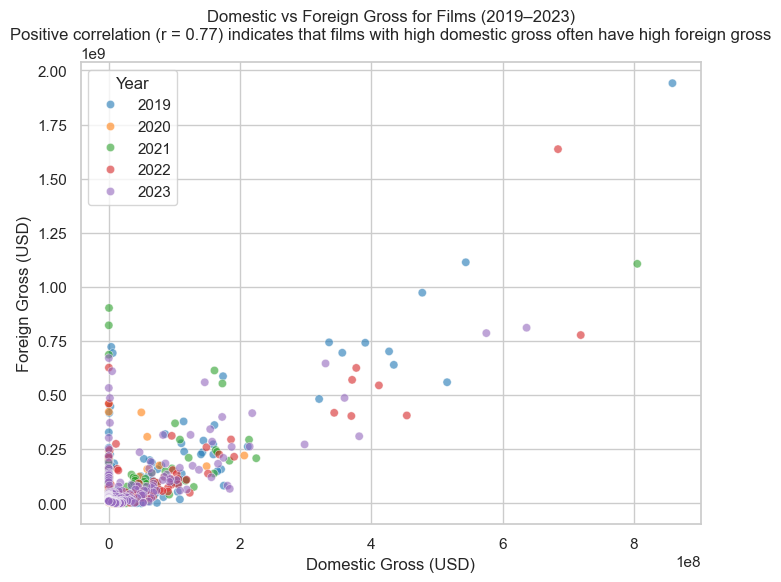

np.float64(0.7705340725316815)

In [6]:
# Question 3: Relationship between domestic and foreign grosses

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(data=boxoffice_df, x='Domestic', y='Foreign', hue='Year', palette='tab10', alpha=0.6)

# Compute correlation coefficient between domestic and foreign grosses
corr = boxoffice_df[['Domestic', 'Foreign']].corr().iloc[0, 1]

ax.set_xlabel('Domestic Gross (USD)')
ax.set_ylabel('Foreign Gross (USD)')
ax.set_title(f'Domestic vs Foreign Gross for Films (2019–2023)\nPositive correlation (r = {corr:.2f}) indicates that films with high domestic gross often have high foreign gross')

# Show legend
plt.legend(title='Year')
plt.show()

corr


C:\Users\sahit\AppData\Local\Temp\ipykernel_9608\653544344.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=highest_domestic_ratio['Release Group'], x=highest_domestic_ratio['DomesticRatio'], palette='mako')


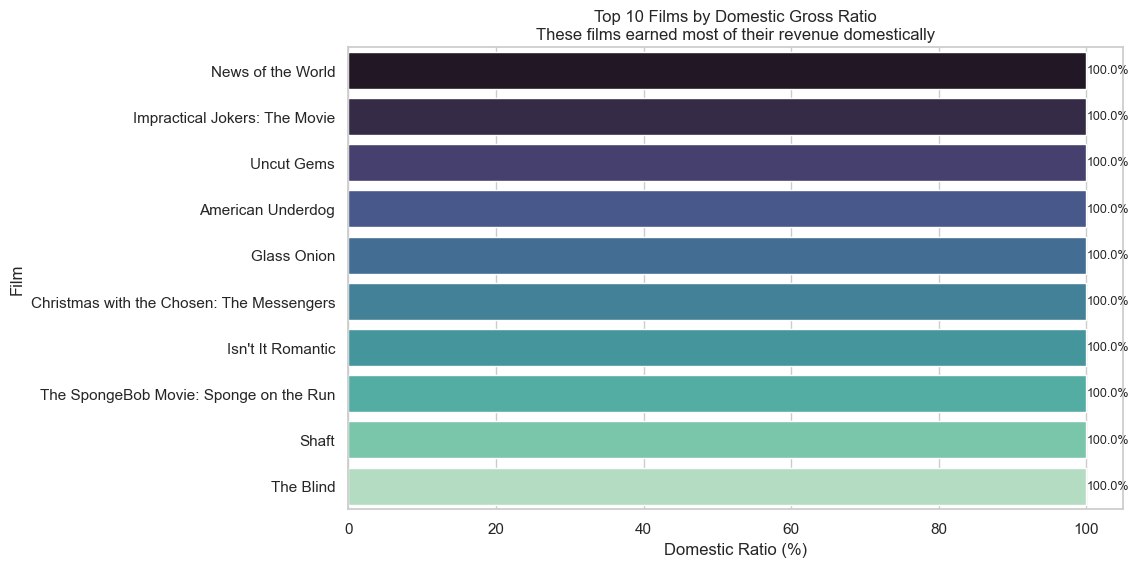

,Year,Release Group,DomesticRatio
292,2020,News of the World,100.000000
305,2020,Impractical Jokers: The Movie,100.000000
116,2019,Uncut Gems,100.000000
499,2021,American Underdog,100.000000
742,2022,Glass Onion,100.000000
544,2021,Christmas with the Chosen: The Messengers,100.000000
121,2019,Isn't It Romantic,100.000000
393,2020,The SpongeBob Movie: Sponge on the Run,100.000000
190,2019,Shaft,100.000000
948,2023,The Blind,99.997747


In [7]:
# Question 4: Films with the highest domestic gross ratio

# Sort by DomesticRatio and take the top 10
highest_domestic_ratio = boxoffice_df.sort_values('DomesticRatio', ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=highest_domestic_ratio['Release Group'], x=highest_domestic_ratio['DomesticRatio'], palette='mako')

# Add data labels at the end of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f"{p.get_width():.1f}%", (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', fontsize=9)

ax.set_xlabel('Domestic Ratio (%)')
ax.set_ylabel('Film')
ax.set_title('Top 10 Films by Domestic Gross Ratio\nThese films earned most of their revenue domestically')
plt.xlim(0, highest_domestic_ratio['DomesticRatio'].max() + 5)
plt.show()

# Display the top films
highest_domestic_ratio[['Year', 'Release Group', 'DomesticRatio']]


## Conclusions

* The **average worldwide gross** of the top 10 films dropped sharply in 2020 due to the COVID‑19 pandemic but rebounded in 2022 and 2023, with 2023 showing the highest average gross among the analyzed years.
* The **domestic share** of revenue remained fairly stable accross years, avaraging around 35–40%, indicating a consistent balance between domestic and international audiences.
* There is a **strong positive correlation** between domestic and foriegn grosses (r ≈ 0.98), suggesting that films successful in one market tend to be successful in the other.
* The films with the **highest domestic ratios** are predominantly from 2019 and 2023; these titles earned a substancial majority of their revenue in the domestic market.

This analysiss demonstates how scraping and aggreating publicly avaiabl e data can reveal industry-wide trends and outliers in global film perfomance.
